# А/B тестирование. Аналитика крупного интернет-магазина


Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

Проект состоит из 2 частей:

1. Приоритизация гипотез
2. Анализ A/B-теста

***Описание данных***

Структура `hypothesis.csv`:
* `Hypothesis` — краткое описание гипотезы,  
* `Reach` — охват пользователей по 10-балльной шкале,  
* `Impact` — влияние на пользователей по 10-балльной шкале,  
* `Confidence` — уверенность в гипотезе по 10-балльной шкале,
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура `orders.csv`:
* `transactionId` — идентификатор заказа,
* `visitorId` — идентификатор пользователя, совершившего заказ,
* `date` — дата, когда был совершён заказ,
* `revenue` — выручка заказа,
* `group` — группа A/B-теста, в которую попал заказ.

Структура `visitors.csv`:
* `date` — дата,
* `group` — группа A/B-теста,
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

**Подготовка**

In [1]:
# Импорт необходимых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import math

In [2]:
# Увеличим ширину отображаемых столбцов
pd.options.display.max_colwidth = 200

In [3]:
# Загрузка данных

# гипотезы
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except FileNotFoundError:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

# покупки    
try:
    orders = pd.read_csv('orders.csv')
except FileNotFoundError:
    orders = pd.read_csv('/datasets/orders.csv')

# посетители   
try:
    visitors = pd.read_csv('visitors.csv')
except FileNotFoundError:
    visitors = pd.read_csv('/datasets/visitors.csv')

### Часть 1. Приоритизация гипотез.

In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
# Поправим регистр
hypothesis.columns= hypothesis.columns.str.lower()

#### 1.1 Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [7]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


#### 1.2 Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [8]:
hypothesis['RICE'] = round(hypothesis['reach'] * hypothesis['impact'] *
                      hypothesis['confidence'] / hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


#### 1.2 Выясним, как изменилась приоритизация гипотез при применении RICE вместо ICE.

Наиболее эффективные гипотезы по фреймфорку ICE с индексом: 8, 0, 7, 6.
Наиболее эффективные гипотезы по фреймворку RICE с индексом: 7, 2, 0, 6. 

Гипотеза 8 с низким показателем Reach ушла с первого места, уступив гипотизе 7 c высоким Reach.

### Часть 2. Анализ A/B-теста

**Таблица orders**

In [9]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
# приведем к формату даты
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [12]:
# проверим количество дубликатов
orders.duplicated().sum()

0

Проверим принадлежность пользователей к сразу двум группам.

In [13]:
# через множества
#a_visitors = set(orders['visitorId'].loc[orders['group'] == 'A'])
#b_visitors = set(orders['visitorId'].loc[orders['group'] == 'B'])
#len(a_visitors.intersection(b_visitors))

In [14]:
# через pandas
a_visitors = orders['visitorId'].loc[orders['group'] == 'A']
orders['visitorId'].loc[(orders['group'] == 'B') & (orders['visitorId'].isin(a_visitors))].nunique()

58

58 пользователей попали одновременно 2 две группы. 

Мы не знаем наверняка было ли на них какое-то воздействие или нет. В данной задаче мы предполагаем, что разбиение на группы было проведено корректно и, оставив всех пользователей в тестовой группе, продолжим исследование.

**Таблица visitors**

In [15]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [16]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [17]:
# приведем к формату даты
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [18]:
# проверим количество дубликатов
visitors.duplicated().sum()

0

#### 2.1 Построим график кумулятивной выручки по группам.

In [19]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [20]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]\
                                     .agg({'date' : 'max', 
                                           'group' : 'max', 
                                           'transactionId' : pd.Series.nunique, 
                                           'visitorId' : pd.Series.nunique, 
                                           'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [21]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                                       .sort_values(by=['date','group']))

In [22]:
# определим переменную cumulativeData
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


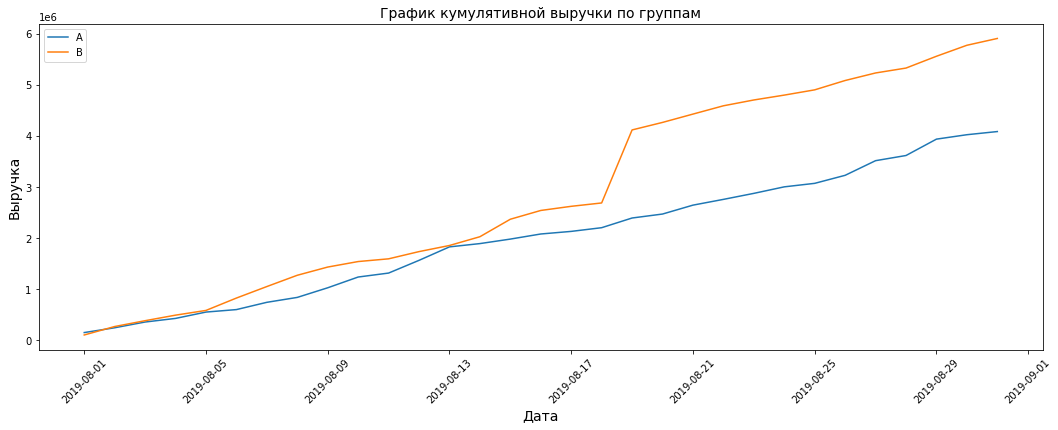

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим графики
plt.figure(figsize=(18,6))
# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Дата', size = 14)
plt.ylabel('Выручка', size = 14)
plt.title('График кумулятивной выручки по группам', size = 14)
plt.show()

**Вывод:**  
Выручка для обеих групп увеличивается в течение всего теста. Наблюдаем вплеск в выборке В на 18.08.2019.

#### 2.2 Построим график кумулятивного среднего чека по группам.

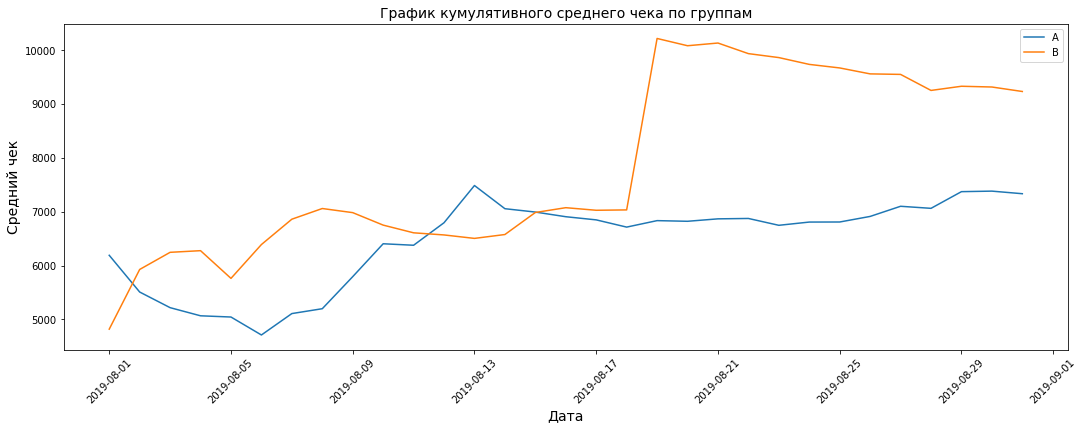

In [24]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(18,6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Дата', size=14)
plt.ylabel('Средний чек', size=14)
plt.title('График кумулятивного среднего чека по группам', size=14)
plt.show()

**Вывод:**   
Также наблюдаем  вплеск в выборке B на 2019-08-18. После чего идет небольшое снижение и выравнивание.

#### 2.3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

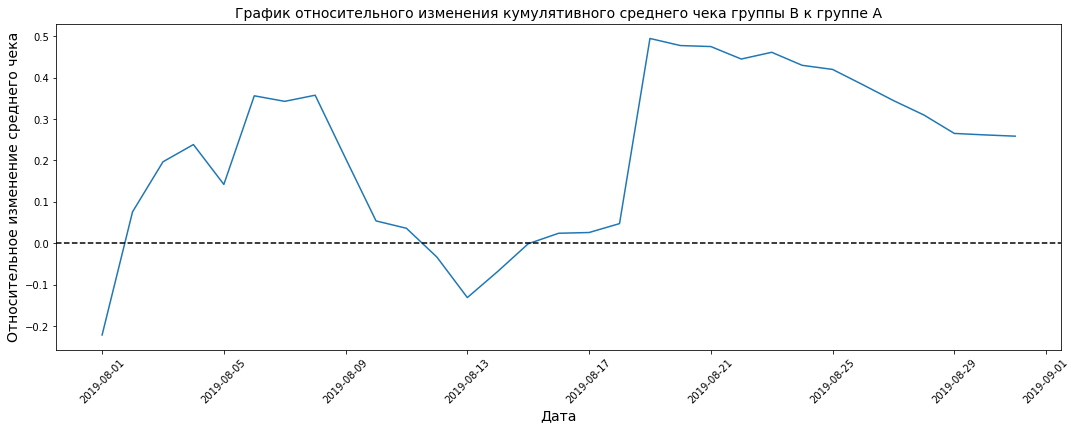

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(18,6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/
                                           mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Дата', size=14)
plt.ylabel('Относительное изменение среднего чека', size=14)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=14)

plt.show()

**Вывод:**  
Наблюдаем частые скачки графика. В эти даты скорее всего были совершены очень большие заказы.

#### 2.4 Построим график кумулятивного среднего количества заказов (конверсию) по группам. 

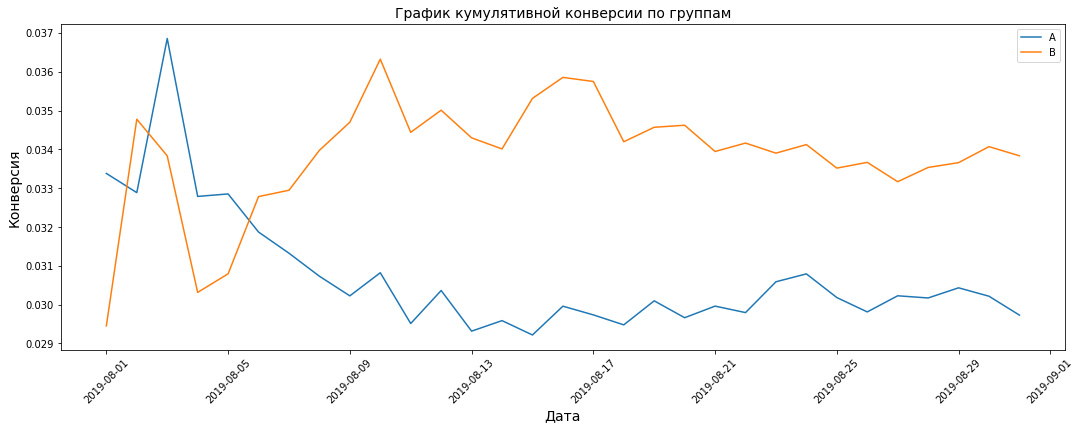

In [26]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(18,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия', size=14)
plt.title('График кумулятивной конверсии по группам', size=14)
plt.show()


**Вывод:**  
Конверсия группы В находится выше А. Но в самом начале аблюдений группа А была выше по конверсии, но затем она упала.

#### 2.5 Построим график относительного изменения кумулятивного среднего количества заказов  (конверсии) группы B к группе A

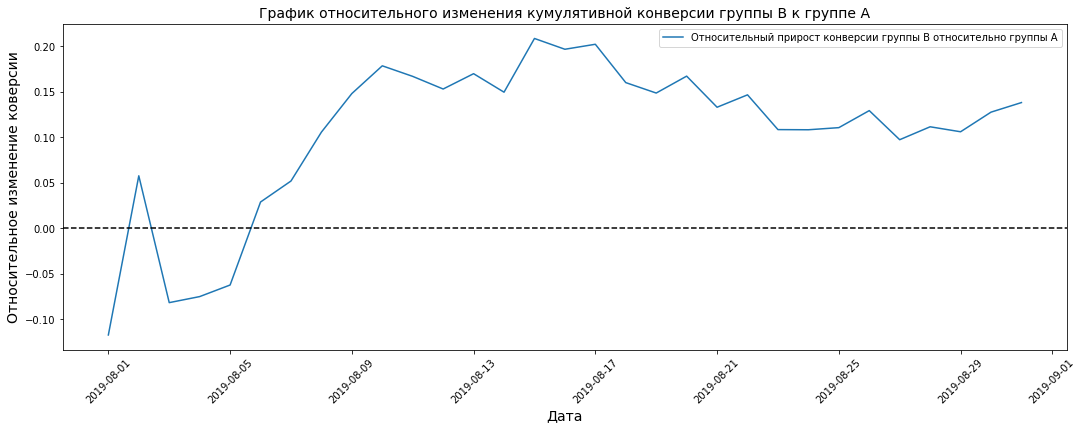

In [27]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(18,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата', size=14)
plt.ylabel('Относительное изменение коверсии', size=14)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size=14)
plt.axhline(y=0, color='black', linestyle='--')
#plt.axhline(y= 0.2, color='grey', linestyle='--')
plt.show()

**Вывод:**  
Группа B растет больше чем группа А.

#### 2.6 Построим точечный график количества заказов по пользователям.

In [28]:
ordersByUsers = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))
ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


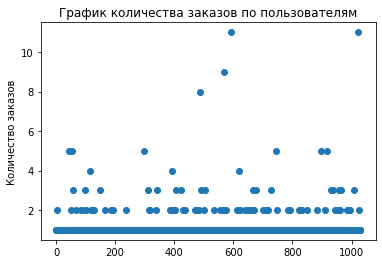

In [29]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Количество заказов')
plt.title('График количества заказов по пользователям')
plt.show()

**Вывод:**  
Основная концентрация приходится на 1-2 заказа. Выше 4 заказов очень мало.

#### 2.7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [30]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод:**  
Не более 5% пользователей совершали больше 2х заказов. Не более 1% пользователей совершали больше 4х заказов. За границу для определения аномальных пользователей можно взять 99-й перцентиль.

#### 2.8 Построим точечный график стоимостей заказов.

Text(0.5, 1.0, 'График стоимости заказов по пользователям')

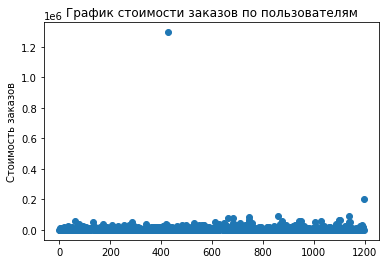

In [31]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказов')
plt.title('График стоимости заказов по пользователям')
#plt.axis([0,1200, 0, 80000])

(0.0, 1200.0, 0.0, 80000.0)

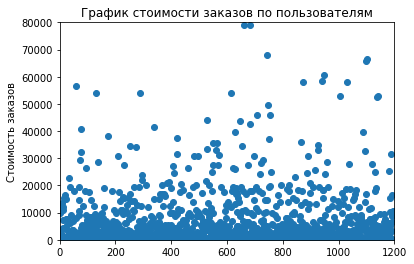

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказов')
plt.title('График стоимости заказов по пользователям')
plt.axis([0,1200, 0, 80000])

**Вывод:** 
Наблюдаем 2 выброса.


#### 2.9 Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [33]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:**  
Не более 5% пользователей совершали заказы на более чем 28000 руб. Не более 1% пользователей совершали заказы на более чем 58233 руб. За границу для определения аномальных пользователей можно взять значение между 95 и 99-м перцентилем.

#### 2.10 Посчитаем статистическую значимость различий в среднем количестве заказов (конверсии) между группами по «сырым» данным. 

Сформулируем гипотезы.

- *Нулевая гипотеза: различий в конверсии между группами нет.*  
- *Альтернативная гипотеза: различия в конверсии между группами есть.*

Критический уровень статистической значимости p-value = 0,05  
Для A/B-тестирования, будем применять критерий Манна-Уитни (st.mannwhitneyu).

In [34]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [35]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']


In [36]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                     name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                     name='orders')],axis=0)

In [37]:
# Воспользуемся критерием Манна-Уитни
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("относительный прирост = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

p-value = 0.017
относительный прирост = 0.138


**Вывод:**  
- Первое число p-value = 0.017, что меньше 0.05.  Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. 
- Относительный выигрыш группы B равен 13.8% — второе число в выводе.    

#### 2.11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы.

- *Нулевая гипотеза: различий в среднем чеке между группами нет.*  
- *Альтернативная гипотеза: различия в среднем чеке между группами есть.*

Критический уровень статистической значимости p-value = 0,05  
Для A/B-тестирования, будем применять критерий Манна-Уитни (st.mannwhitneyu).

In [38]:
# Воспользуемся критерием Манна-Уитни
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))
print("относительный прирост = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.729
относительный прирост = 0.259


**Вывод:**  
- P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
- Средний чек группы B значительно выше среднего чека группы A.

####  2.12 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Подготовим очищенные от аномалий данные.
95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.
Примем за аномальных пользователей тех, кто совершил 4 заказа и более, или совершил заказ на сумму свыше 40 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% заказов с наибольшей стоимостью.

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
Name: visitorId, dtype: int64
34


Найдено 34 аномальных случаев. Отфильтруем группы.

Сформулируем гипотезы.

- *Нулевая гипотеза: различий в конверсии между группами нет.*  
- *Альтернативная гипотеза: различия в конверсии между группами есть.*

Критический уровень статистической значимости p-value = 0,05  
Для A/B-тестирования, будем применять критерий Манна-Уитни (st.mannwhitneyu).

In [40]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# Воспользуемся критерием Манна-Уитни

print('p-value = {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительный прирост = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.00931
относительный прирост = 0.164


**Вывод:**  
- Величина P-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем.  
- Относительный выигрыш группы B равен 16.4% — второе число в выводе. Это выше (был 13.8%) чем в "сырых данных".
- Сильных различий в "сырых" и "очищенных" не наблюдаем.
   

#### 2.13 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы.

- *Нулевая гипотеза: различий в среднем чеке между группами нет.*  
- *Альтернативная гипотеза: различия в среднем чеке между группами есть.*

Критический уровень статистической значимости p-value = 0,05  
Для A/B-тестирования, будем применять критерий Манна-Уитни (st.mannwhitneyu).

In [41]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "относительный прирост = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.711
относительный прирост = 0.060


**Вывод:**  

- P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
- Средний чек группы B немного выше среднего чека группы A.
- Сильных различий в "сырых" и "очищенных" не наблюдаем.

#### 2.14 Примем решение по результатам теста.


- Наблюдаем статистически значимые различия по конверсии между группами А и В как для случая с "сырыми" данными, так и с "очищенными".
- Видим существенное преобладание группы B по конверсии в обоих исследованиях.
- После чистки наблюдаем, что преобладание среднего чека у группы B стало несколько ниже (возможно это было обусловлено наличием какого-то крупного заказа). Однако нельзя сделать вывод о статистически значимом различим по среднему  чеку между группами А и В как для случая с "сырыми" данными, так и с "очищенными".

Исходя из этого, останавливаем тест, группу B считаем лучше.

### Общий вывод:  


#### Часть 1. Приоритизация гипотез

Для приоритизации гипотез были применены фреймворк ICE и RICE.   
Наиболее эффективные гипотезы по фреймфорку ICE с индексом: 8, 0, 7, 6.  
Наиболее эффективные гипотезы по фреймворку RICE с индексом: 7, 2, 0, 6.   
  
Гипотеза 8 с низким показателем Reach ушла с первого места, уступив гипотизе 7 c высоким Reach.  


#### Часть 2. Анализ A/B-теста:  

- Построены графики кумулятивной выручки и кумулятивного среднего чека по группам;
- Построены графики кумулятивной конверсии по группам, относительного изменения конверсии;
- Построены графики относительного изменения кумулятивного среднего чека группы B к группе A;
- Построен точечный график количества заказов по пользователям и стоимостей заказов;
- Посчитаны 95-й и 99-й перцентили количества заказов на пользователя и стоимости заказов;
- Посчитаны статистические значимости различий в конверсии и среднем чеке заказа между группами по «сырым» данным;
- Посчитаны статистические значимости различий в конверсии и среднем чеке заказа между группами по «очищеным» данным;

По итогам теста принято решение об остановке теста и признания его успешным. 
 
Группа B статистически значимо лучше группы A.
Среднее количество заказов увеличилось при отсутствии значимых изменений по среднему чеку. Следовательно, увеличилась и выручка, так как пользователи стали покупать чаще.